<a href="https://www.kaggle.com/code/praths71018/eye-disease-detection?scriptVersionId=171534185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-disease-deep-learning-dataset/dataset/labels.csv
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/623.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/208.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/473.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/333.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/537.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/45.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/369.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/56.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/654.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/89.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/20.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/275.jpg
/kaggle/input/eye-disease-deep-learning-dataset/dataset/images/212.jpg
/kaggle/input/

# Importing Modules

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import os
import random
import matplotlib.image as mpimg
import cv2
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report , confusion_matrix

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

warnings.filterwarnings('ignore')

2024-04-11 15:09:33.531965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 15:09:33.532090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 15:09:33.616573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Dataset and EDA

In [3]:
path='/kaggle/input/eye-disease-deep-learning-dataset/dataset/labels.csv'
df=pd.read_csv(path)
df.head()

name  category  type  grade
0  1.jpg         0     4      3
1  2.jpg         0     4      3
2  3.jpg         0     2      2
3  4.jpg         0     2      1
4  5.jpg         0     1      3

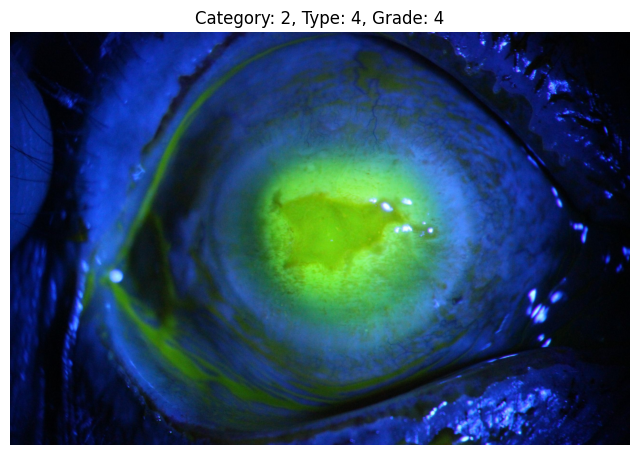

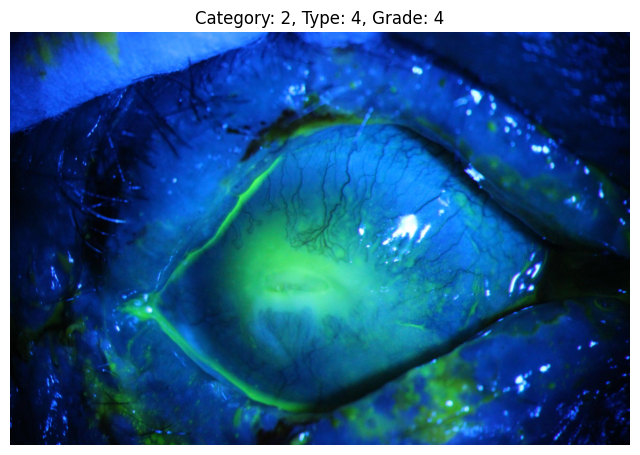

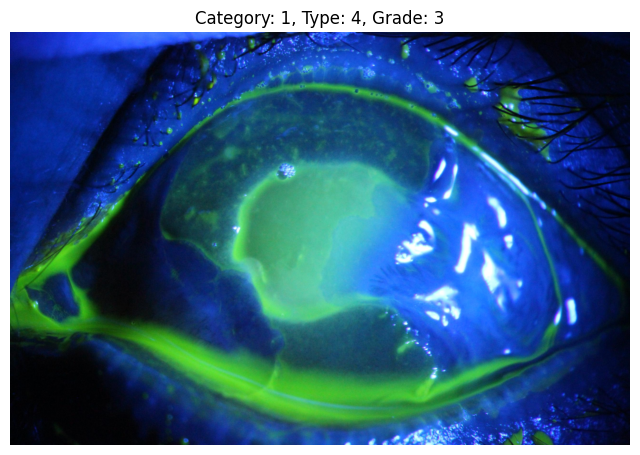

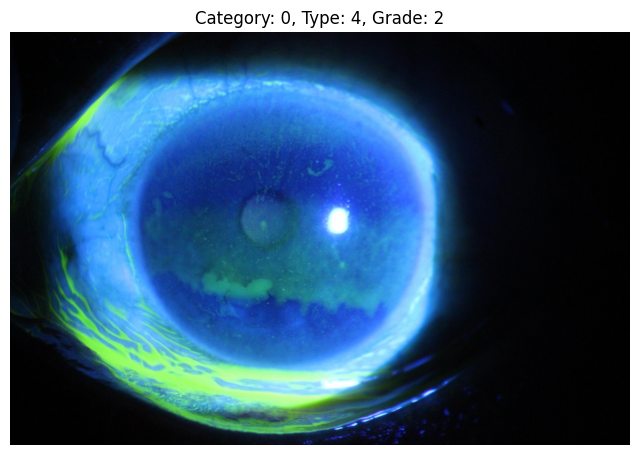

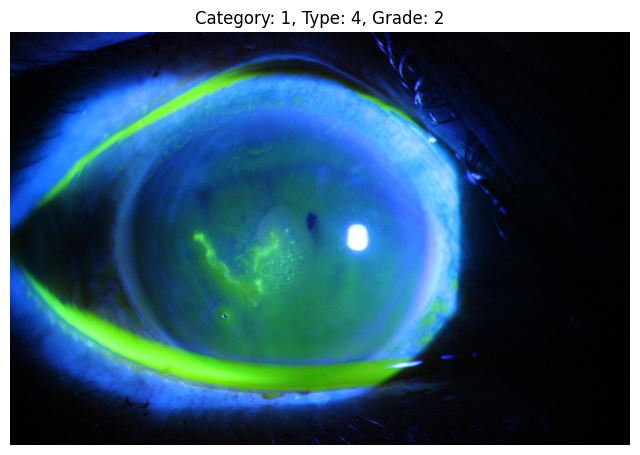

In [4]:
# Directory containing images
image_dir = "/kaggle/input/eye-disease-deep-learning-dataset/dataset/images"

# Load dataset
csv_file_path = "/kaggle/input/eye-disease-deep-learning-dataset/dataset/labels.csv"
dataset = pd.read_csv(csv_file_path)

# Select five random images
random_image_indices = random.sample(range(len(dataset)), 5)

# Display the selected images with labels
for idx in random_image_indices:
    image_path = os.path.join(image_dir, dataset.loc[idx, 'name'])
    image = mpimg.imread(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Category: {dataset.loc[idx, 'category']}, Type: {dataset.loc[idx, 'type']}, Grade: {dataset.loc[idx, 'grade']}")
    plt.axis('off')
    plt.show()


In [5]:
Type_of_category=df['category'].unique()
Type_of_category

array([0, 1, 2])

In [6]:
Type_of_diseases=df['type'].unique()
Type_of_diseases

array([4, 2, 1, 0, 3])

In [7]:
Type_of_grade=df['grade'].unique()
Type_of_grade

array([3, 2, 1, 0, 4])

In [8]:
dic={}
for i in Type_of_diseases:
    dic[i]=df['type'].value_counts()[i]
    
dic_category={}
for j in Type_of_category:
    dic_category[j]=df['category'].value_counts()[j]
    
dic_grade={}
for k in Type_of_grade:
    dic_grade[k]=df['grade'].value_counts()[k]

print(dic)
print(dic_category)
print(dic_grade)

{4: 548, 2: 40, 1: 78, 0: 36, 3: 10}
{0: 358, 1: 263, 2: 91}
{3: 273, 2: 203, 1: 98, 0: 36, 4: 102}


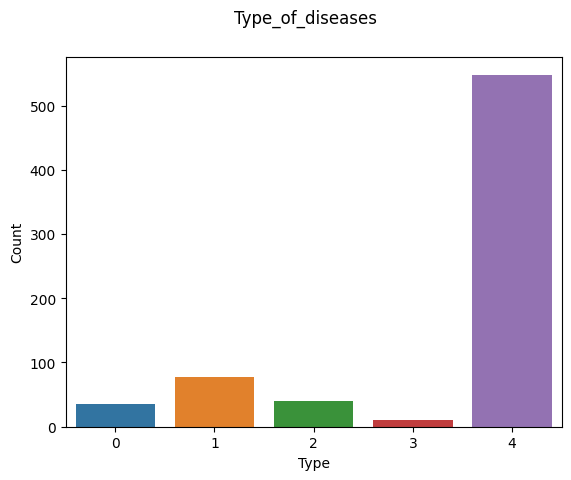

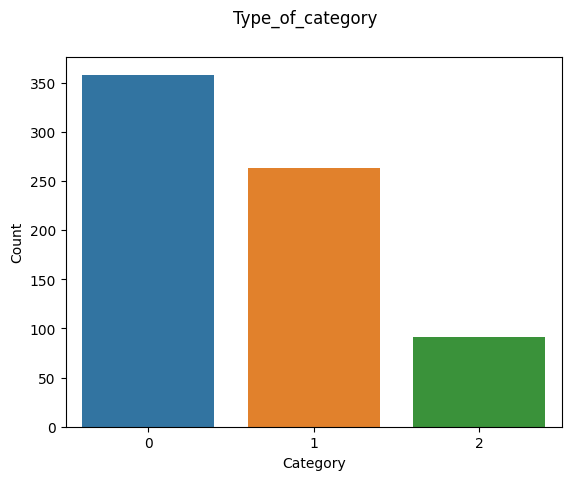

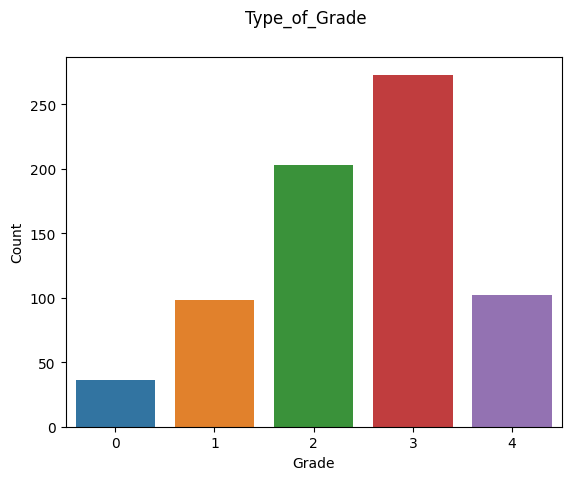

In [9]:
sns.barplot(x = list(dic.keys()), y = list(dic.values()))
plt.suptitle("Type_of_diseases")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_category.keys()), y = list(dic_category.values()))
plt.suptitle("Type_of_category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_grade.keys()), y = list(dic_grade.values()))
plt.suptitle("Type_of_Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

# Data Augmentation

In [10]:
# Load the dataset
dataset = df

# Function to augment images
def augment_image(image_path):
    image = cv2.imread(image_path)
    # Apply augmentation techniques here
    # For example, you can add rotation, flipping, scaling, etc.
    augmented_images = [image]  # Initial image
    # Example: Rotate the image
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(rotated_image)
    return augmented_images

# Define paths
input_folder = "/kaggle/input/eye-disease-deep-learning-dataset/dataset/images"  # Folder containing original images
output_folder = "augmented_images"  # Folder to store augmented images

# Create output folder if not exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Augment images and append to the dataset
augmented_dataset = []
for index, row in dataset.iterrows():
    image_name = row['name']
    image_path = os.path.join(input_folder, image_name)
    augmented_images = augment_image(image_path)
    for augmented_image in augmented_images:
        augmented_image_name = f"{os.path.splitext(image_name)[0]}_augmented.jpg"
        augmented_image_path = os.path.join(output_folder, augmented_image_name)
        cv2.imwrite(augmented_image_path, augmented_image)
        augmented_row = {
            'name': augmented_image_name,
            'category': row['category'],
            'type': row['type'],
            'grade': row['grade']
        }
        augmented_dataset.append(augmented_row)

# Convert augmented dataset to DataFrame
augmented_dataset_df = pd.DataFrame(augmented_dataset)

# Append augmented dataset to original dataset
combined_dataset = pd.concat([dataset, augmented_dataset_df], ignore_index=True)

# Save combined dataset to CSV
combined_dataset.to_csv("combined_dataset.csv", index=False)


In [11]:
# Source and destination paths
source_images_folder = "/kaggle/input/eye-disease-deep-learning-dataset/dataset/images"
destination_images_folder = "/kaggle/working/augmented_images"

# Copy images
if os.path.exists(source_images_folder) and os.path.isdir(source_images_folder):
    if not os.path.exists(destination_images_folder):
        os.makedirs(destination_images_folder)
    # Copy contents of source_images_folder to destination_images_folder
    for file_name in os.listdir(source_images_folder):
        source_file = os.path.join(source_images_folder, file_name)
        destination_file = os.path.join(destination_images_folder, file_name)
        shutil.copyfile(source_file, destination_file)
else:
    print("Source images folder not found.")


In [12]:
df=combined_dataset
df

name  category  type  grade
0                 1.jpg         0     4      3
1                 2.jpg         0     4      3
2                 3.jpg         0     2      2
3                 4.jpg         0     2      1
4                 5.jpg         0     1      3
...                 ...       ...   ...    ...
2131  710_augmented.jpg         2     1      4
2132  711_augmented.jpg         2     3      4
2133  711_augmented.jpg         2     3      4
2134  712_augmented.jpg         2     4      4
2135  712_augmented.jpg         2     4      4

[2136 rows x 4 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2136 entries, 0 to 2135
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      2136 non-null   object
 1   category  2136 non-null   int64 
 2   type      2136 non-null   int64 
 3   grade     2136 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 66.9+ KB


In [14]:
train_image='/kaggle/working/augmented_images'
train_image

'/kaggle/working/augmented_images'

In [15]:
df.nunique()

name        1424
category       3
type           5
grade          5
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2136 entries, 0 to 2135
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      2136 non-null   object
 1   category  2136 non-null   int64 
 2   type      2136 non-null   int64 
 3   grade     2136 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 66.9+ KB


In [17]:
Type_of_category=df['category'].unique()
Type_of_category

array([0, 1, 2])

In [18]:
Type_of_diseases=df['type'].unique()
Type_of_diseases

array([4, 2, 1, 0, 3])

In [19]:
Type_of_grade=df['grade'].unique()
Type_of_grade

array([3, 2, 1, 0, 4])

In [20]:
dic={}
for i in Type_of_diseases:
    dic[i]=df['type'].value_counts()[i]
    
dic_category={}
for j in Type_of_category:
    dic_category[j]=df['category'].value_counts()[j]
    
dic_grade={}
for k in Type_of_grade:
    dic_grade[k]=df['grade'].value_counts()[k]

print(dic)
print(dic_category)
print(dic_grade)

{4: 1644, 2: 120, 1: 234, 0: 108, 3: 30}
{0: 1074, 1: 789, 2: 273}
{3: 819, 2: 609, 1: 294, 0: 108, 4: 306}


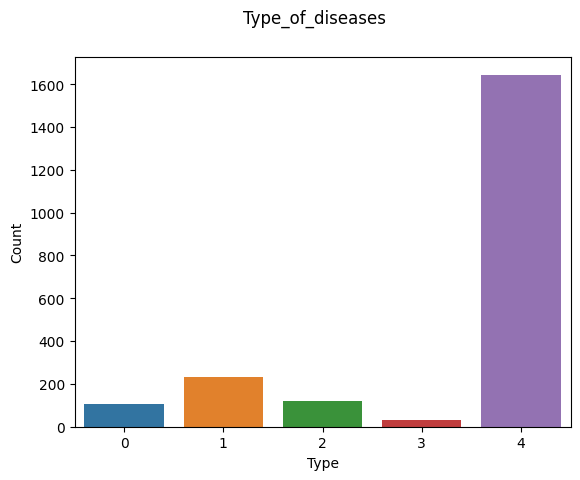

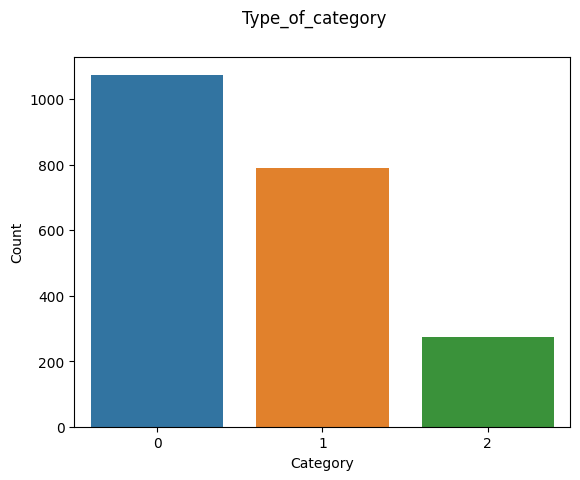

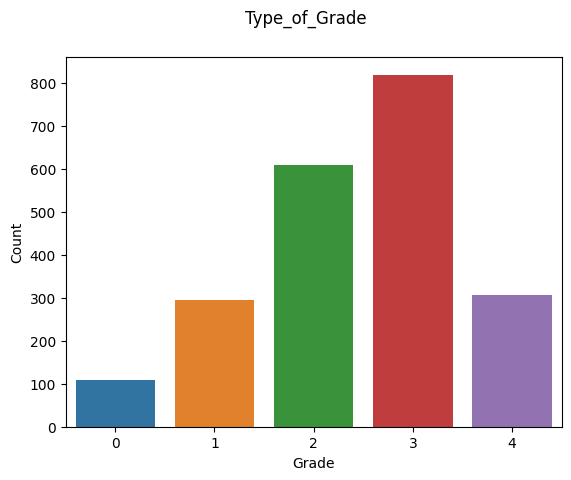

In [21]:
sns.barplot(x = list(dic.keys()), y = list(dic.values()))
plt.suptitle("Type_of_diseases")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_category.keys()), y = list(dic_category.values()))
plt.suptitle("Type_of_category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_grade.keys()), y = list(dic_grade.values()))
plt.suptitle("Type_of_Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

# Model Building

## Category

In [22]:
from tensorflow.keras.preprocessing import image

train_images = []

for i in tqdm(range(df.shape[0])):
    img = image.load_img('/kaggle/working/augmented_images/'+df['name'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    img = img/255
#     train_images.append(img)
    train_images.append(img)

X = np.array(train_images)
X[0:10]

100%|██████████| 2136/2136 [00:50<00:00, 42.63it/s]


array([[[[0.00784314, 0.01568628, 0.0627451 ],
         [0.00784314, 0.01568628, 0.0627451 ],
         [0.01176471, 0.01960784, 0.06666667],
         ...,
         [0.00784314, 0.02352941, 0.05882353],
         [0.00392157, 0.01960784, 0.0627451 ],
         [0.00392157, 0.01960784, 0.0627451 ]],

        [[0.00784314, 0.01568628, 0.0627451 ],
         [0.01176471, 0.01960784, 0.06666667],
         [0.01176471, 0.01960784, 0.06666667],
         ...,
         [0.01960784, 0.02745098, 0.11764706],
         [0.00784314, 0.02352941, 0.07058824],
         [0.00784314, 0.02352941, 0.06666667]],

        [[0.01568628, 0.01568628, 0.0627451 ],
         [0.01960784, 0.02745098, 0.07843138],
         [0.01960784, 0.02745098, 0.07843138],
         ...,
         [0.01568628, 0.02745098, 0.16470589],
         [0.00392157, 0.02352941, 0.10196079],
         [0.01176471, 0.01960784, 0.06666667]],

        ...,

        [[0.00784314, 0.02745098, 0.05098039],
         [0.01176471, 0.02745098, 0.0627451 ]

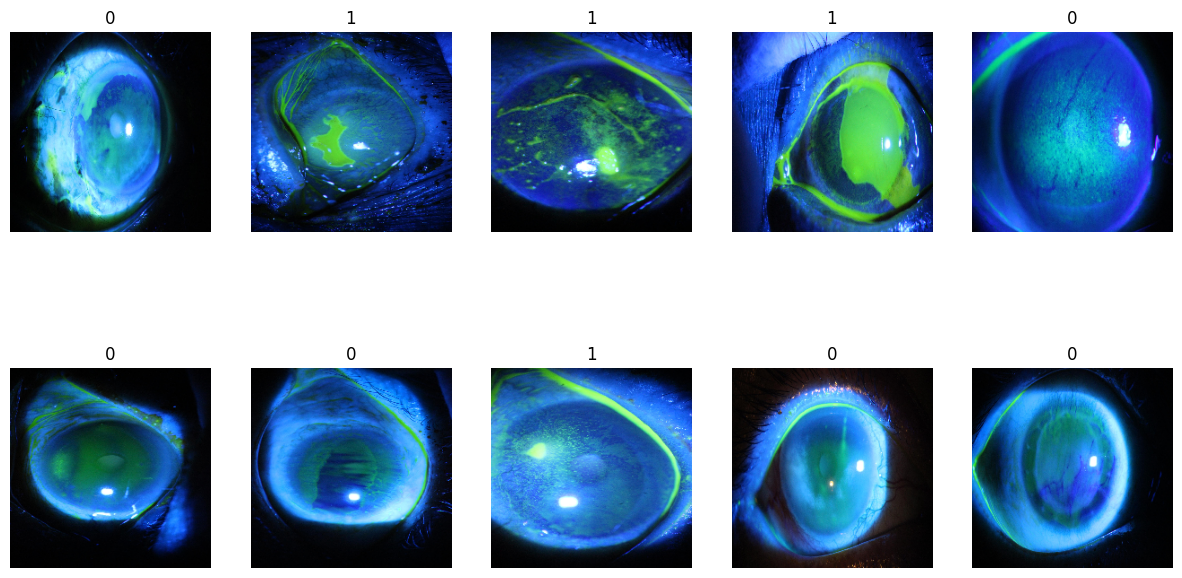

In [23]:
# Select 10 random indices
sample_indices = random.sample(range(len(train_images)), 10)

# Display the images with their corresponding labels
plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[idx])
    plt.title(df['category'][idx])  # Accessing label directly from DataFrame
    plt.axis('off')
plt.show()


In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['category'].values, test_size=0.3, random_state=42)

In [25]:
# Define the CNN architecture
input_layer = Input(shape=(224, 224, 3))

In [26]:
# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


# Flatten layer
flatten = Flatten()(pool2)

# Fully connected layers with L2 regularization
dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(flatten)
dropout1 = Dropout(0.7)(dense1)
dense2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer
output_layer = Dense(len(df['category'].unique()), activation='softmax')(dropout2)

In [27]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,703,491 (365.08 MB)

 Trainable params: 95,703,491 (365.08 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
 2/47 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.2109 - loss: 17.0411  

I0000 00:00:1712848460.177345      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712848460.194652      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4470 - loss: 13.9213

W0000 00:00:1712848480.384196      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712848481.952958      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - accuracy: 0.4488 - loss: 13.8399 - val_accuracy: 0.6771 - val_loss: 4.6793
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6125 - loss: 3.9963 - val_accuracy: 0.6412 - val_loss: 2.7591
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6821 - loss: 2.5818 - val_accuracy: 0.6708 - val_loss: 2.3414
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6555 - loss: 2.3385 - val_accuracy: 0.6537 - val_loss: 2.0940
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6912 - loss: 2.1039 - val_accuracy: 0.7410 - val_loss: 2.0916
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7256 - loss: 1.9870 - val_accuracy: 0.7051 - val_loss: 1.8345
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7041 - loss: 1.7863 - val_accuracy: 0.7083 - val_loss: 1.7472
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6984 - loss: 1.7168 - val_accuracy: 0.6864 - val_loss:

In [29]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

W0000 00:00:1712848518.143101      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Accuracy: 0.725083589553833
Test Accuracy: 0.6957878470420837


In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


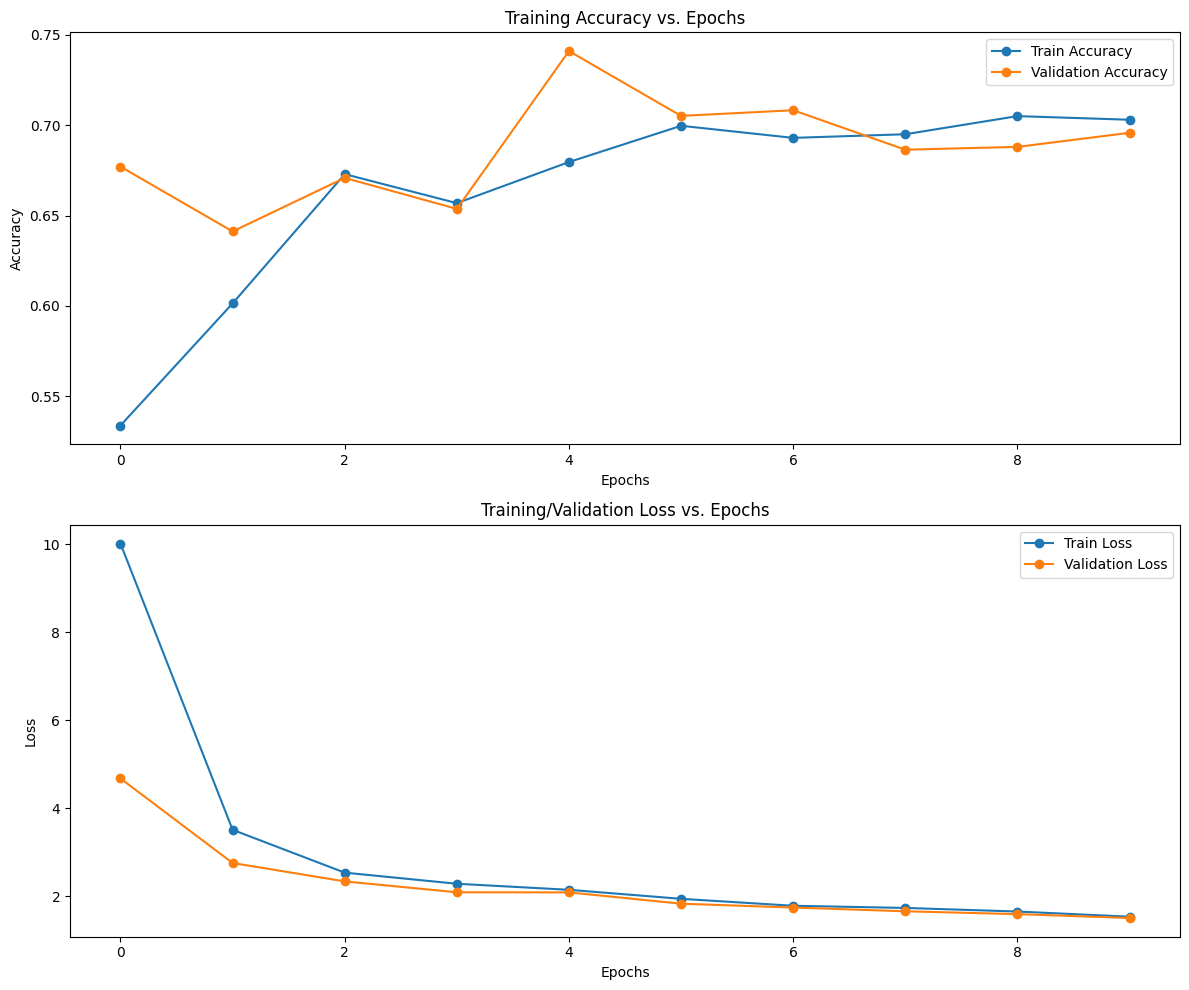

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()


In [32]:
y_test

array([1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 2, 1, 0, 0, 1,
       0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0,
       1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 2,
       0, 1, 0, 0, 1, 1, 2, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 1, 2, 2,
       0, 2, 2, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2,
       1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2,

In [33]:
y_pred=model.predict(X_test) 
y_pred

13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

W0000 00:00:1712848522.551606      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


array([[0.10071602, 0.6643448 , 0.23493919],
       [0.6806601 , 0.2298253 , 0.08951461],
       [0.21010461, 0.49126166, 0.29863372],
       ...,
       [0.8638029 , 0.10575487, 0.03044219],
       [0.90417653, 0.07685504, 0.01896849],
       [0.908985  , 0.07247492, 0.01854009]], dtype=float32)

In [34]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [35]:
y_pred_train=model.predict(X_train) 
y_pred_train

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


W0000 00:00:1712848526.633085      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.3296951e-01, 5.3885136e-02, 1.3145327e-02],
       [6.5942752e-01, 2.4866869e-01, 9.1903798e-02],
       [6.0541672e-04, 5.6264973e-01, 4.3674487e-01],
       ...,
       [9.3907779e-01, 4.9536116e-02, 1.1386153e-02],
       [8.8137633e-01, 9.5179386e-02, 2.3444328e-02],
       [9.1806012e-01, 6.6995069e-02, 1.4944879e-02]], dtype=float32)

In [36]:
y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_pred_classes_train

array([0, 0, 1, ..., 0, 0, 0])

In [37]:
class_counts = np.bincount(y_train)

# Print the counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count} instances")

Class 0: 764 instances
Class 1: 532 instances
Class 2: 199 instances


In [38]:
class_counts = np.bincount(y_pred_classes_train)

# Print the counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count} instances")

Class 0: 1004 instances
Class 1: 457 instances
Class 2: 34 instances


In [39]:
print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79       310
           1       0.74      0.58      0.65       257
           2       0.56      0.07      0.12        74

    accuracy                           0.70       641
   macro avg       0.66      0.53      0.52       641
weighted avg       0.69      0.70      0.66       641



## Type

In [40]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, df['type'].values, test_size=0.3, random_state=42)

In [41]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layers in the base model (optional, depending on fine-tuning strategy)
for layer in base_model.layers:
    layer.trainable = False

# Add custom head for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)  # Assuming 5 output classes

# Create a new model
model1 = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model1.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
model1.fit(X_train1, y_train1, epochs=9, batch_size=64, validation_data=(X_test1, y_test1),verbose=1)

Epoch 1/9
 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3637 - loss: 2.1762

W0000 00:00:1712848549.485382      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6354 - loss: 1.3932

W0000 00:00:1712848558.604354      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712848562.884843      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 758ms/step - accuracy: 0.6384 - loss: 1.3798 - val_accuracy: 0.7941 - val_loss: 0.5995
Epoch 2/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7884 - loss: 0.6675 - val_accuracy: 0.8019 - val_loss: 0.5523
Epoch 3/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7992 - loss: 0.5795 - val_accuracy: 0.8034 - val_loss: 0.5316
Epoch 4/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8242 - loss: 0.5384 - val_accuracy: 0.8066 - val_loss: 0.4963
Epoch 5/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8134 - loss: 0.5154 - val_accuracy: 0.8081 - val_loss: 0.5002
Epoch 6/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8310 - loss: 0.4803 - val_accuracy: 0.8331 - val_loss: 0.4594
Epoch 7/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8406 - loss: 0.4457 - val_accuracy: 0.8346 - val_loss: 0.4586
Epoch 8/9
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8777 - loss: 0.3573 - val_accuracy: 0.8300 - val_loss: 0.4394


In [43]:
# Evaluate the model
train_loss1, train_accuracy1 = model1.evaluate(X_train1, y_train1, verbose=0)
print("Training Accuracy:", train_accuracy1)
test_loss1, test_accuracy1 = model1.evaluate(X_test1, y_test1, verbose=0)
print("Test Accuracy:", test_accuracy1)

W0000 00:00:1712848592.158805      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712848595.440441      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Accuracy: 0.9217391014099121
Test Accuracy: 0.8393135666847229


In [44]:
train_accuracy1 = history.history['accuracy']
val_accuracy1 = history.history['val_accuracy']

train_loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

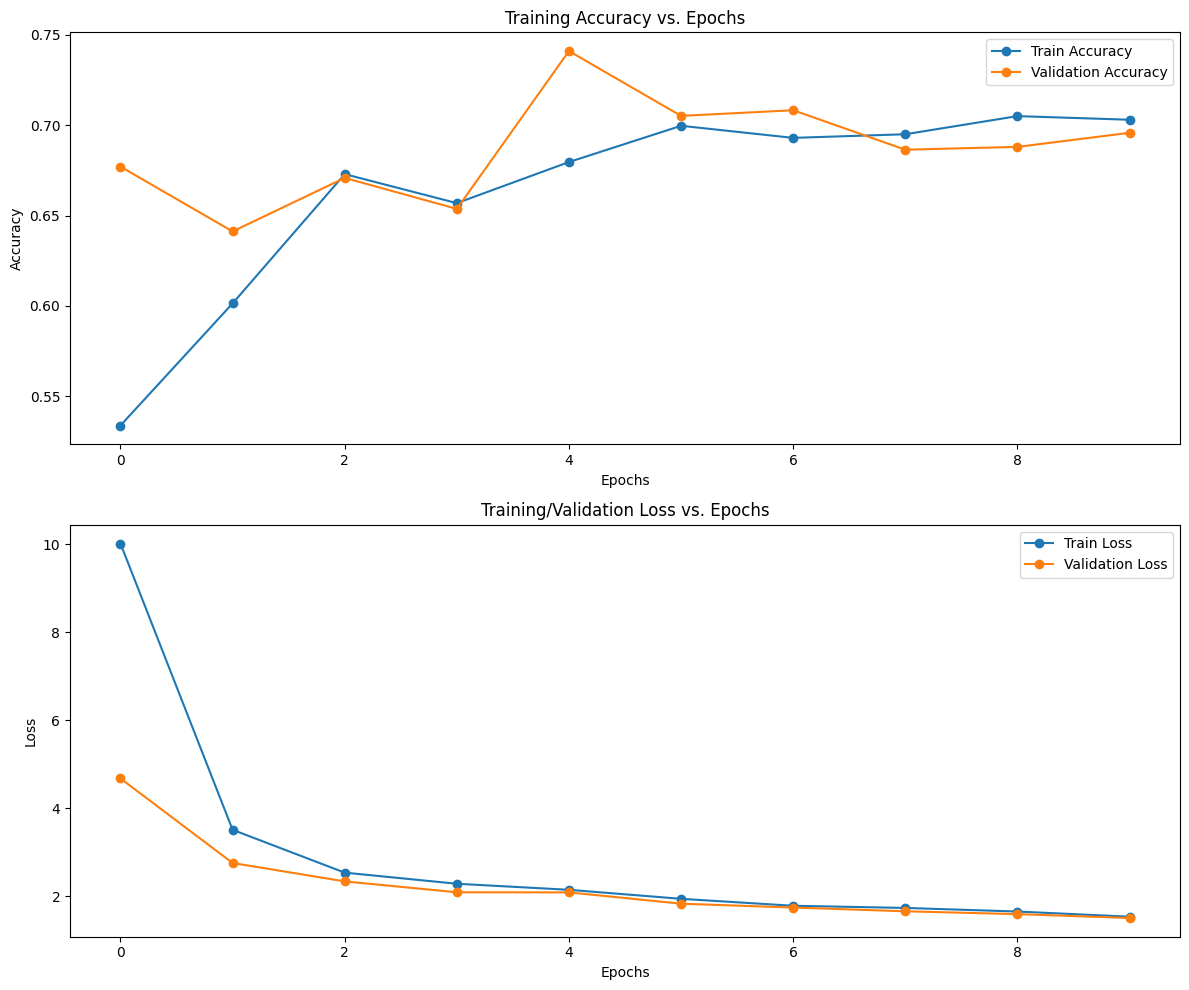

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy1, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy1, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss1, 'o-', label='Train Loss')
ax[1].plot(val_loss1, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

In [46]:
y_test1

array([4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 2, 4, 3,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4,
       1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4,
       4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 2, 4, 4, 4, 0, 4, 3, 4, 4, 1, 4, 4,
       3, 1, 4, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 0, 4, 2, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 2, 4, 4, 4, 1, 0, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 3, 4, 2, 4, 3,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,

In [47]:
y_pred1=model1.predict(X_test1) 
y_pred1

 7/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

W0000 00:00:1712848603.257632      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step


array([[1.47361704e-03, 2.72909421e-02, 6.44919649e-02, 2.45549786e-03,
        9.04287934e-01],
       [3.40664410e-03, 2.40851268e-02, 1.78451184e-02, 1.90160889e-03,
        9.52761531e-01],
       [1.62140396e-03, 1.45404935e-02, 2.46415734e-02, 3.20697390e-03,
        9.55989599e-01],
       ...,
       [9.48725492e-02, 2.00536579e-01, 2.90150553e-01, 2.45706700e-02,
        3.89869690e-01],
       [2.56974483e-03, 3.93851884e-02, 3.38618271e-02, 2.22150795e-03,
        9.21961725e-01],
       [4.21616714e-03, 6.87707448e-04, 2.80717239e-02, 1.26935751e-03,
        9.65755045e-01]], dtype=float32)

In [48]:
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_pred_classes1

array([4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 2, 4,
       1, 2, 4, 4, 4, 4, 4, 4, 2, 4, 1, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 1, 1, 2, 4, 1, 4, 2, 4, 4, 4, 0, 4, 4, 4, 4, 1, 4, 4,
       4, 2, 4, 4, 4, 4, 0, 1, 4, 2, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1,

In [49]:
print(classification_report(y_test1,y_pred_classes1))

              precision    recall  f1-score   support

           0       0.47      0.24      0.32        33
           1       0.67      0.51      0.58        61
           2       0.48      0.56      0.51        36
           3       0.00      0.00      0.00         9
           4       0.89      0.95      0.92       502

    accuracy                           0.84       641
   macro avg       0.50      0.45      0.47       641
weighted avg       0.81      0.84      0.82       641



In [50]:
y_pred1_train=model1.predict(X_train1) 
y_pred1

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


W0000 00:00:1712848613.001288      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[1.47361704e-03, 2.72909421e-02, 6.44919649e-02, 2.45549786e-03,
        9.04287934e-01],
       [3.40664410e-03, 2.40851268e-02, 1.78451184e-02, 1.90160889e-03,
        9.52761531e-01],
       [1.62140396e-03, 1.45404935e-02, 2.46415734e-02, 3.20697390e-03,
        9.55989599e-01],
       ...,
       [9.48725492e-02, 2.00536579e-01, 2.90150553e-01, 2.45706700e-02,
        3.89869690e-01],
       [2.56974483e-03, 3.93851884e-02, 3.38618271e-02, 2.22150795e-03,
        9.21961725e-01],
       [4.21616714e-03, 6.87707448e-04, 2.80717239e-02, 1.26935751e-03,
        9.65755045e-01]], dtype=float32)

In [51]:
y_pred_classes1_train = np.argmax(y_pred1_train, axis=1)
y_pred_classes1_train

array([4, 4, 4, ..., 2, 4, 4])

In [52]:
class_counts = np.bincount(y_pred_classes1_train)

# Print the counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count} instances")

Class 0: 67 instances
Class 1: 155 instances
Class 2: 99 instances
Class 3: 6 instances
Class 4: 1168 instances


In [53]:
y_train1

array([4, 4, 4, ..., 2, 4, 0])

In [54]:
class_counts = np.bincount(y_train1)

# Print the counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count} instances")

Class 0: 75 instances
Class 1: 173 instances
Class 2: 84 instances
Class 3: 21 instances
Class 4: 1142 instances


## Grade 

In [55]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, df['grade'].values, test_size=0.3, random_state=42)

In [56]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layers in the base model (optional, depending on fine-tuning strategy)
for layer in base_model.layers:
    layer.trainable = False

# Add custom head for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)  # Assuming 5 output classes

# Create a new model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
# Train the model
history = model.fit(X_train2, y_train2, epochs=25, batch_size=32, validation_split=0.2,verbose=1)


Epoch 1/25
 5/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2764 - loss: 2.0247

W0000 00:00:1712848627.952876      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3537 - loss: 1.6982

W0000 00:00:1712848635.533181      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712848638.966569      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 429ms/step - accuracy: 0.3546 - loss: 1.6938 - val_accuracy: 0.4682 - val_loss: 1.2381
Epoch 2/25
 3/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5486 - loss: 1.1527

W0000 00:00:1712848643.846216      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4949 - loss: 1.2098 - val_accuracy: 0.4548 - val_loss: 1.2848
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5466 - loss: 1.1088 - val_accuracy: 0.4716 - val_loss: 1.1713
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5223 - loss: 1.0910 - val_accuracy: 0.4314 - val_loss: 1.2928
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5708 - loss: 1.0245 - val_accuracy: 0.5452 - val_loss: 1.1212
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6235 - loss: 0.9208 - val_accuracy: 0.5017 - val_loss: 1.0881
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6559 - loss: 0.8346 - val_accuracy: 0.5217 - val_loss: 1.1007
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6783 - loss: 0.8287 - val_accuracy: 0.5686 - val_loss: 1.0658
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6614 - loss: 0.8048 - val_accuracy: 0.5786 - val_loss: 1.

In [58]:
# Evaluate the model
train_loss2, train_accuracy2 = model.evaluate(X_train2, y_train2, verbose=0)
print("Training Accuracy:", train_accuracy2)
test_loss2, test_accuracy2 = model.evaluate(X_test2, y_test2, verbose=0)
print("Test Accuracy:", test_accuracy2)

W0000 00:00:1712848686.312233      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Accuracy: 0.9003344774246216
Test Accuracy: 0.6536661386489868


In [59]:
train_accuracy2 = history.history['accuracy']
val_accuracy2 = history.history['val_accuracy']

train_loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

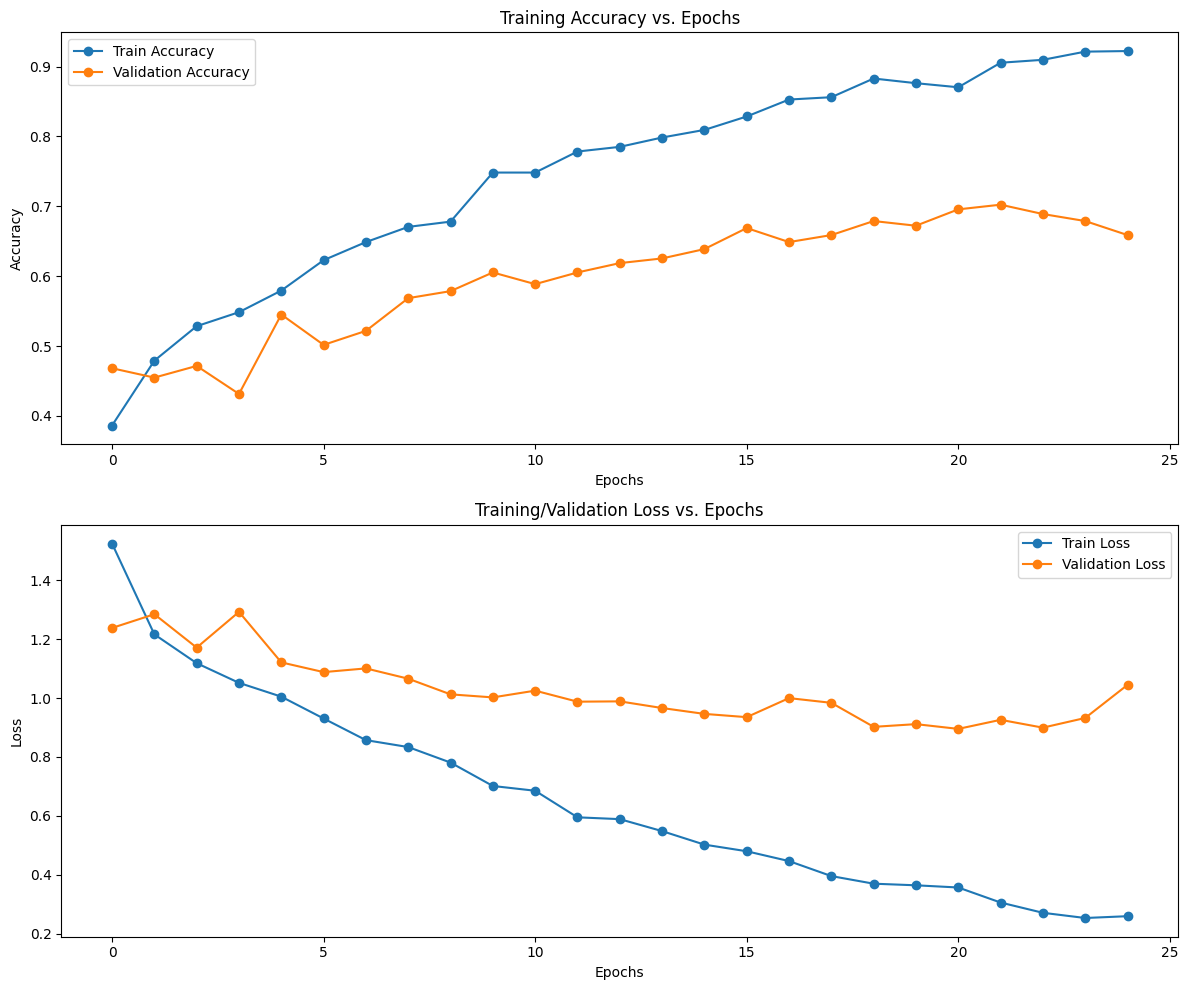

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy2, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy2, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss2, 'o-', label='Train Loss')
ax[1].plot(val_loss2, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

In [61]:
y_test2

array([3, 2, 2, 3, 2, 2, 2, 4, 3, 2, 4, 1, 4, 2, 2, 3, 2, 3, 3, 3, 2, 3,
       3, 4, 3, 3, 3, 2, 3, 1, 3, 3, 2, 3, 4, 1, 3, 4, 3, 4, 3, 3, 2, 3,
       2, 3, 3, 4, 3, 1, 3, 2, 2, 3, 2, 2, 2, 4, 4, 3, 1, 1, 3, 2, 3, 4,
       3, 2, 3, 2, 0, 3, 2, 3, 2, 2, 2, 4, 3, 1, 2, 0, 2, 3, 3, 2, 4, 2,
       1, 3, 3, 2, 2, 3, 2, 3, 1, 1, 3, 3, 4, 3, 2, 3, 3, 3, 2, 3, 1, 3,
       2, 3, 3, 3, 4, 1, 2, 3, 3, 3, 2, 1, 2, 4, 3, 3, 3, 3, 2, 4, 2, 3,
       3, 2, 2, 4, 4, 3, 2, 3, 3, 0, 3, 2, 2, 2, 0, 3, 4, 1, 4, 3, 3, 2,
       1, 2, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 2, 3, 1, 1, 1, 2, 1, 2, 4, 4,
       3, 3, 3, 4, 3, 4, 2, 2, 1, 1, 3, 3, 2, 3, 0, 2, 3, 3, 2, 1, 2, 3,
       2, 1, 3, 4, 3, 2, 4, 2, 2, 4, 2, 2, 3, 3, 3, 3, 2, 4, 4, 3, 3, 3,
       3, 4, 3, 0, 1, 2, 0, 0, 2, 2, 3, 2, 3, 1, 4, 3, 2, 4, 3, 3, 3, 4,
       3, 3, 2, 3, 1, 2, 4, 0, 4, 2, 4, 2, 3, 3, 4, 2, 3, 3, 3, 3, 4, 4,
       2, 4, 4, 1, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 4,
       2, 1, 3, 3, 4, 3, 4, 2, 1, 3, 1, 3, 3, 3, 4,

In [62]:
y_pred2=model.predict(X_test2) 
y_pred2

 7/21 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

W0000 00:00:1712848696.181803      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step


array([[1.9566830e-04, 5.5498172e-02, 2.8830564e-01, 6.4388096e-01,
        1.2119525e-02],
       [3.9812562e-04, 6.0019456e-03, 2.8052923e-01, 7.1261245e-01,
        4.5824089e-04],
       [1.7805508e-04, 1.9777877e-02, 1.7386381e-01, 7.9859245e-01,
        7.5879004e-03],
       ...,
       [1.9112021e-02, 7.1178937e-01, 1.3800311e-01, 1.1616180e-01,
        1.4933564e-02],
       [4.5374363e-06, 1.1806217e-03, 3.2878097e-03, 9.9513370e-01,
        3.9339269e-04],
       [4.4871034e-05, 4.8335938e-04, 4.5790488e-01, 5.4138386e-01,
        1.8303559e-04]], dtype=float32)

In [63]:
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_pred_classes2

array([3, 3, 3, 3, 2, 2, 2, 4, 3, 3, 3, 1, 4, 2, 2, 3, 3, 3, 3, 3, 2, 3,
       4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 4, 1, 3, 3, 3, 4, 3, 3, 2, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 2, 2, 4, 4, 3, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 1, 3, 2, 3, 2, 3, 3, 4, 2, 4, 3,
       1, 3, 3, 3, 2, 3, 2, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 2, 3, 3, 3, 1, 2, 3, 3, 2, 3, 1, 3, 3, 3, 3, 4, 3, 3, 4, 2, 2,
       3, 2, 2, 4, 1, 3, 2, 3, 3, 3, 3, 2, 3, 3, 0, 3, 4, 3, 4, 3, 3, 3,
       1, 2, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 4, 1, 2, 1, 2, 2, 3, 3, 3,
       3, 2, 3, 3, 3, 4, 2, 3, 4, 3, 3, 3, 3, 3, 0, 2, 3, 3, 2, 1, 1, 3,
       3, 2, 3, 4, 2, 1, 2, 4, 2, 4, 4, 2, 3, 4, 3, 3, 2, 4, 3, 3, 3, 3,
       3, 4, 3, 2, 1, 2, 3, 0, 2, 2, 3, 2, 3, 4, 4, 3, 2, 4, 3, 3, 4, 4,
       3, 3, 2, 3, 1, 3, 4, 2, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 4,
       3, 3, 4, 1, 1, 3, 2, 3, 2, 1, 3, 2, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3,
       2, 4, 3, 3, 4, 2, 4, 2, 1, 3, 2, 3, 3, 3, 4,

In [64]:
print(classification_report(y_test2,y_pred_classes2))

              precision    recall  f1-score   support

           0       0.92      0.33      0.49        33
           1       0.70      0.47      0.56        89
           2       0.74      0.50      0.60       184
           3       0.61      0.91      0.73       245
           4       0.63      0.58      0.60        90

    accuracy                           0.65       641
   macro avg       0.72      0.56      0.60       641
weighted avg       0.68      0.65      0.64       641

